number of trainable parameters: 3.32M
Epoch 1: Training Loss = 3.990898265182972, Validation Loss = 4.003190623223782


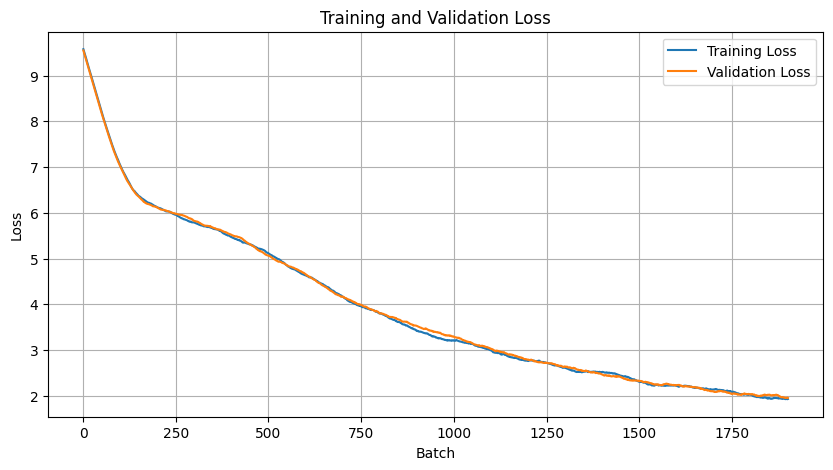

In [2]:
"""
Training file for the models we implemented 
"""

from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.utils
from torch.utils.data import DataLoader
from einops import rearrange
import wandb

from model import BigramLanguageModel, MiniGPT
from dataset import TinyStoriesDataset
from config import BigramConfig, MiniGPTConfig


MODEL = "minigpt"  # bigram or minigpt

if MODEL == "bigram":
    config = BigramConfig
    model = BigramLanguageModel(config)
elif MODEL == "minigpt":
    config = MiniGPTConfig
    model = MiniGPT(config)
else:
    raise ValueError("Invalid model name")


# Initialize wandb if you want to use it
# if config.to_log:
#     wandb.init(project="dl2_proj3")


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


train_dataset = TinyStoriesDataset(
    config.path_to_data,
    mode="train",
    context_length=config.context_length,
)
eval_dataset = TinyStoriesDataset(
    config.path_to_data, mode="test", context_length=config.context_length
)

train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, pin_memory=True
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=config.batch_size, pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("number of trainable parameters: %.2fM" % (count_parameters(model) / 1e6,))


if not Path.exists(config.save_path):
    Path.mkdir(MiniGPTConfig.save_path, parents=True, exist_ok=True)


### ==================== START OF YOUR CODE ==================== ###
"""
You are required to implement the training loop for the model.

Please keep the following in mind:
- You will need to define an appropriate loss function for the model.
- You will need to define an optimizer for the model.
- You are required to log the loss (either on wandb or any other logger you prefer) every `config.log_interval` iterations.
- It is recommended that you save the model weights every `config.save_iterations` iterations you can also just save the model with the best training loss.

Please check the config file to see the different configurations you can set for the model.
NOTE : 
The MiniGPT config has params that you do not need to use, these were added to scale the model but are 
not a required part of the assignment. 
Feel free to experiment with the parameters and I would be happy to talk to you about them if interested :)
"""

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Initialize SummaryWriter for TensorBoard logging
writer = SummaryWriter()

# Initialize variables for tracking training and validation loss
train_losses = []
eval_losses = []

# Define the number of batches for training and validation
# Change number of batches depending on bigram or minigpt model
num_batches = 2000

# Training and validation loop
for epoch in range(1):
    model.train()
    train_loss_epoch = 0  
    val_loss_epoch = 0  
    
    for i in range(num_batches):
        # Training
        train_batch = next(iter(train_dataloader))
        inputs, labels = train_batch
        inputs, labels = inputs.to(device), labels.squeeze(dim=1).to(device)  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        loss.backward()
        optimizer.step()
        writer.add_scalar('Training Loss', loss.item(), epoch * num_batches + i)
        train_losses.append(loss.item())
        train_loss_epoch += loss.item()
        
        # Validation
        eval_batch = next(iter(eval_dataloader))
        inputs, labels = eval_batch
        inputs, labels = inputs.to(device), labels.squeeze(dim=1).to(device)  # Move data to device
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        writer.add_scalar('Validation Loss', loss.item(), epoch * num_batches + i)
        eval_losses.append(loss.item())
        val_loss_epoch += loss.item()

    # Average epoch losses
    train_loss_epoch /= num_batches
    val_loss_epoch /= num_batches
    
    # Print or log epoch losses
    print(f"Epoch {epoch + 1}: Training Loss = {train_loss_epoch}, Validation Loss = {val_loss_epoch}")

# Close the SummaryWriter
writer.close()

# Function to compute moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Apply moving average to smooth the curves
window_size = 100  
smoothed_train_losses = moving_average(train_losses, window_size)
smoothed_eval_losses = moving_average(eval_losses, window_size)

# Plot training and validation loss over the same number of steps
plt.figure(figsize=(10, 5))
num_steps = min(len(smoothed_train_losses), len(smoothed_eval_losses))  
plt.plot(np.arange(1, num_steps + 1), smoothed_train_losses[:num_steps], label="Training Loss")
plt.plot(np.arange(1, num_steps + 1), smoothed_eval_losses[:num_steps], label="Validation Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss_minigpt.png") # Update depending on bigram or minigpt
plt.show()
